## Imports And Some Settings

In [1]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.datasets import load_boston
tf.keras.backend.set_floatx('float64')
import seaborn as sns

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 980, pci bus id: 0000:26:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Loading Data With sklearn. Creating Train, Val And Test Datasets

    1. CRIM - per capita crime rate by town
    2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    3. INDUS - proportion of non-retail business acres per town.
    4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    5. NOX - nitric oxides concentration (parts per 10 million)
    6. RM - average number of rooms per dwelling
    7. AGE - proportion of owner-occupied units built prior to 1940
    8. DIS - weighted distances to five Boston employment centres
    9. RAD - index of accessibility to radial highways
    10. TAX - full-value property-tax rate per 10,000 USD
    11. PTRATIO - pupil-teacher ratio by town
    12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    13. LSTAT - % lower status of the population
    14. MEDV - Median value of owner-occupied homes in 1000's USD

In [2]:
boston_dataset = load_boston()
boston_keys = boston_dataset.keys()

X_dataset = boston_dataset['data']
y_dataset = boston_dataset['target']

border = int(X_dataset.shape[0] * 0.8)

print("Train dataset size:", border)
print("Test dataset size:",X_dataset.shape[0] - border)

Train dataset size: 404
Test dataset size: 102


## Make pd.dataFrames From nd.arrays

In [3]:
def ndarray_to_dataFrame(data, labels=None):
    index = np.arange(0,data.shape[0],1)
    return pd.DataFrame(data=data, index=index, columns=labels)

In [4]:
x_columns_names = boston_dataset['feature_names']
y_column_name = np.array(['PRICE'])
X_dataset = ndarray_to_dataFrame(X_dataset, x_columns_names)
y_dataset = ndarray_to_dataFrame(y_dataset, y_column_name)
y_train = y_dataset[:border]
X_test = X_dataset[border:]
y_test = y_dataset[border:]

In [5]:
X_train = X_dataset[:border]
y_train = y_dataset[:border]
X_test = X_dataset[border:]
y_test = y_dataset[border:]

## Dataset Preview

In [6]:
ds = pd.DataFrame.join(X_train, y_train)
ds[:10]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


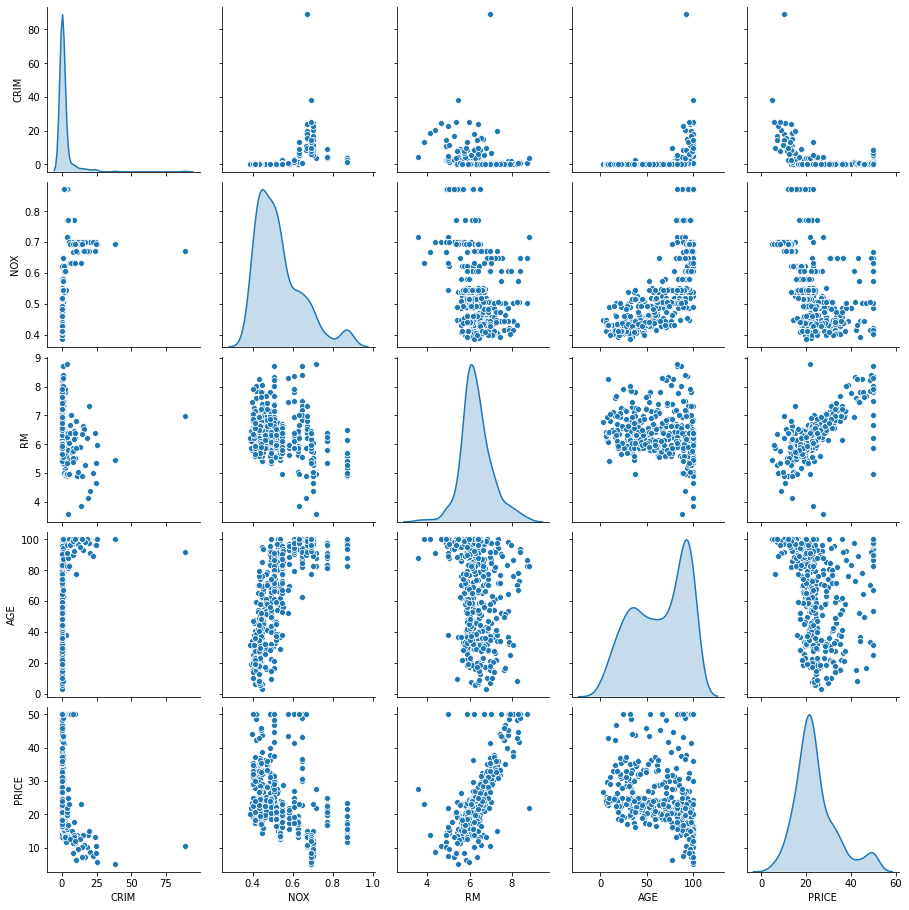

In [7]:
sns.pairplot(ds[["CRIM", "NOX", "RM", "AGE", "PRICE"]], diag_kind="kde")

In [8]:
train_stats = X_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,404.0,1.915899,6.218916,0.00632,0.066358,0.165995,0.775792,88.9762
ZN,404.0,14.232673,25.311515,0.00000,0.000000,0.000000,20.250000,100.0000
INDUS,404.0,9.502327,6.536251,0.46000,4.330000,7.225000,15.040000,25.6500
CHAS,404.0,0.086634,0.281646,0.00000,0.000000,0.000000,0.000000,1.0000
NOX,404.0,0.531732,0.114497,0.38500,0.442000,0.507000,0.605000,0.8710
RM,404.0,6.333109,0.731923,3.56100,5.890500,6.227500,6.679250,8.7800
AGE,404.0,64.427475,29.053901,2.90000,38.025000,69.550000,92.250000,100.0000
DIS,404.0,4.174214,2.181423,1.12960,2.287225,3.842850,5.623350,12.1265
RAD,404.0,6.789604,6.504268,1.00000,4.000000,5.000000,6.000000,24.0000
TAX,404.0,352.910891,131.554089,187.00000,276.000000,307.000000,403.000000,666.0000


## Dataset Normalization

In [9]:
def norm(x):
    train_stats = x.describe().transpose()
    return (x - train_stats['mean']) / train_stats['std']

In [12]:
X_train = norm(X_train)
X_test = norm(X_test)
y_train = norm(y_train)
y_test = norm(y_test)
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.307060,0.148838,-1.100375,-0.307597,0.054744,0.330487,0.026589,-0.038605,-0.890124,-0.432605,-1.227919,0.417806,-0.934279
1,-0.303685,-0.562300,-0.372129,-0.307597,-0.547891,0.120082,0.498127,0.363472,-0.736379,-0.843082,-0.101899,0.417806,-0.324611
2,-0.303688,-0.562300,-0.372129,-0.307597,-0.547891,1.163907,-0.114528,0.363472,-0.736379,-0.843082,-0.101899,0.317354,-1.073506
3,-0.302871,-0.562300,-1.120264,-0.307597,-0.643963,0.908416,-0.641135,0.865484,-0.582633,-0.995111,0.303468,0.361780,-1.233251
4,-0.296973,-0.562300,-1.120264,-0.307597,-0.643963,1.111989,-0.352017,0.865484,-0.582633,-0.995111,0.303468,0.417806,-0.882985
5,-0.303276,-0.562300,-1.120264,-0.307597,-0.643963,0.132379,-0.197133,0.865484,-0.582633,-0.995111,0.303468,0.349193,-0.900572
6,-0.293879,-0.068454,-0.249734,-0.307597,-0.067530,-0.438719,0.074776,0.635496,-0.275143,-0.318583,-1.272959,0.385721,0.157554
7,-0.284833,-0.068454,-0.249734,-0.307597,-0.067530,-0.220117,1.090130,0.814279,-0.275143,-0.318583,-1.272959,0.417806,1.142401
8,-0.274109,-0.068454,-0.249734,-0.307597,-0.067530,-0.959265,1.224363,0.874607,-0.275143,-0.318583,-1.272959,0.164332,2.722261
9,-0.280734,-0.068454,-0.249734,-0.307597,-0.067530,-0.449649,0.739058,1.108399,-0.275143,-0.318583,-1.272959,0.166307,0.841964


## Tensorflow Regression: Implementation

In [ ]:
advanced_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(x_columns_names)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

optimizer = tf.keras.optimizers.RMSprop(0.001)

advanced_model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

advanced_model.summary()

In [ ]:
EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = advanced_model.fit(
    X_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

In [ ]:
plt.plot(history.history['val_loss'])
history.history.keys()

In [ ]:
print(X_test)
test_predictions = advanced_model.predict(X_test)
plt.plot(test_predictions)
test_predictions

## Had-made Linear Regression: Implementation (Normal Eqaution)

## Hand-made Linear Regression: Model Selection

## Comparison Of Tensorflow And Hand-made Implementations: